<a href="https://colab.research.google.com/github/pachterlab/synchromesh/blob/main/notebooks/comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --continue --quiet https://github.com/LuyiTian/sc_mixology/raw/master/data/csv/sc_10x.count.csv.gz
!gunzip sc_10x.count.csv.gz

In [2]:
!pip install --quiet pyreadr git+http://github.com/dirguis/ipfn@master

     |████████████████████████████████| 361 kB 12.1 MB/s 


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import PCA
from collections import OrderedDict

from scipy.sparse import csr_matrix
from scipy.io import mmread
from scipy import stats
from ipfn import ipfn


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
%config InlineBackend.figure_format = 'retina'

In [3]:
def do_ipf(mtx, axis_uniform = 1, iter=1):
  rows, cols = mtx.shape

  n = 1
  if axis_uniform == 1:
    aggregates = [
                  np.ones(rows)*n/rows, # rows, each cell uniform
                  nd(mtx.sum(0))/mtx.sum() # columns, each tag proportional
                  ]
  elif axis_uniform == 0:
    aggregates = [
                  nd(mtx.sum(1))/mtx.sum(), # rows, each cell proportional
                  np.ones(cols)*n/cols, # columns, each tag uniform
                  ]
  elif axis_uniform == -1:
    aggregates = [
                  np.ones(rows)*n/rows, # rows, each cell uniform,
                  np.ones(cols)*n/cols, # columns, each tag uniform
                  ]
  dimensions = [[0], [1]]

  IPF = ipfn.ipfn(mtx.copy(), aggregates, dimensions, max_iteration=100_000)
  m = IPF.iteration()
  del mtx

  return m

# def iter_ipf(mtx, iter=1):
#   print("iter: ", iter)
#   log1p = np.log1p(mtx)
#   mtx_ipf = do_ipf(log1p.copy(), axis_uniform=1)
#   mtx_ipf *= log1p.sum()

#   mtx_new = np.exp(mtx_ipf) - 1
#   iter-=1
#   if iter > 0:
#     return iter_ipf(mtx_new, iter)
  
#   return mtx_new

def iter_ipf(mtx, iter=1):
  print("iter: ", iter)
  mtx_new = mtx.copy()
  for i in range(iter):
    print(f"{i+1} out of {iter}")
    log1p = np.log1p(mtx_new)
    mtx_ipf = do_ipf(log1p.copy(), axis_uniform=1)
    mtx_ipf *= log1p.sum()

    mtx_new = np.exp(mtx_ipf) - 1
  
  return mtx_new


# mtx_ipf = do_ipf(mtx.copy(), axis_uniform=1) # 0: uniform cols, 1: uniform rows, -1: both uniform
# mtx_ipf *= mtx_ipf.sum()

In [7]:
df = pd.read_csv("sc_10x.count.csv").T
mtx = df.values
bcs = df.index.values
genes = df.columns.values

In [8]:
df.shape

(902, 16468)

In [9]:
mtx_log1p = np.log1p(mtx)
mtx_log1p_ipf = do_ipf(mtx_log1p.copy(), axis_uniform=1)
mtx_log1p_ipf *= mtx_log1p.sum()
mtx_log1p_cpm = normalize(mtx_log1p, norm="l1")*1e6
mtx_multiple_ipf = iter_ipf(mtx, iter=10)

iter:  10
1 out of 10
2 out of 10
3 out of 10
4 out of 10
5 out of 10
6 out of 10
7 out of 10
8 out of 10
9 out of 10
10 out of 10


In [10]:
matrices = [mtx, mtx_log1p, mtx_log1p_cpm, mtx_log1p_ipf, np.log1p(mtx_multiple_ipf)]
labels = ["raw", "log1p", "log1p -> cpm", "log1p -> ipf", "log1p -> ipf (10x)"]

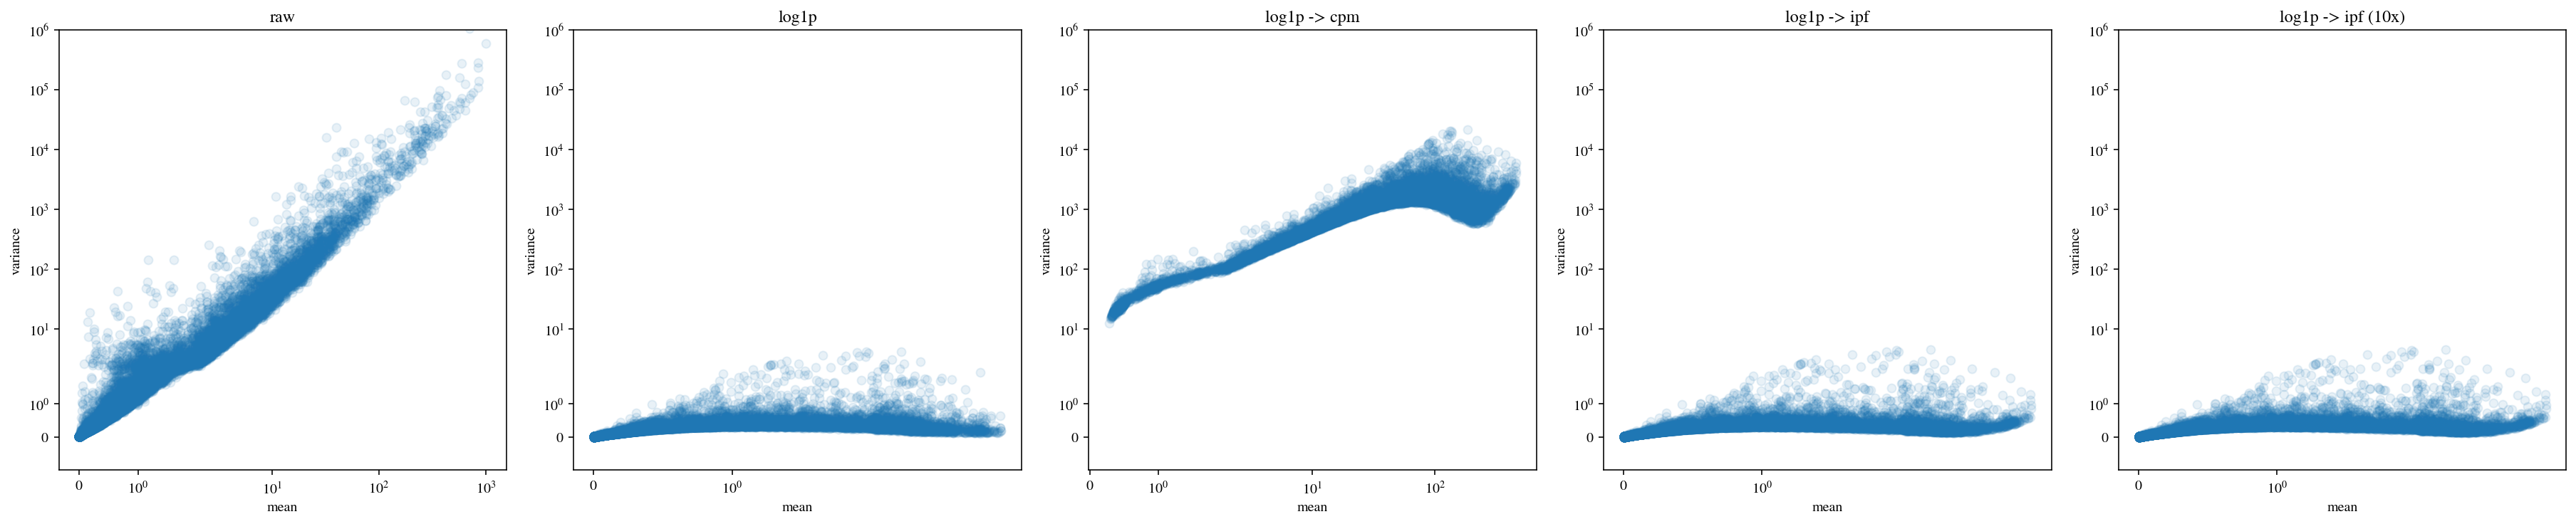

In [11]:
# fix ylim
n = len(matrices)
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

p = {
    "xlabel": "mean",
    "ylabel": "variance",
    "xscale": "symlog",
    "yscale": "symlog",
    "ylim": (-1, 1e6)
}

for idx, matrix in enumerate(matrices):

  ax = axs[idx]
  title = labels[idx]

  x = np.mean(matrix, axis=0)
  y = np.var(matrix, axis=0)
  ax.scatter(x, y, alpha=0.1)
  p.update({"title": title})
  ax.set(**p)

fig.show()

In [12]:
pcs = []
for matrix in matrices:
  pca = PCA(n_components=50, svd_solver='full')
  Y = pca.fit_transform(matrix)
  pcs.append(Y)

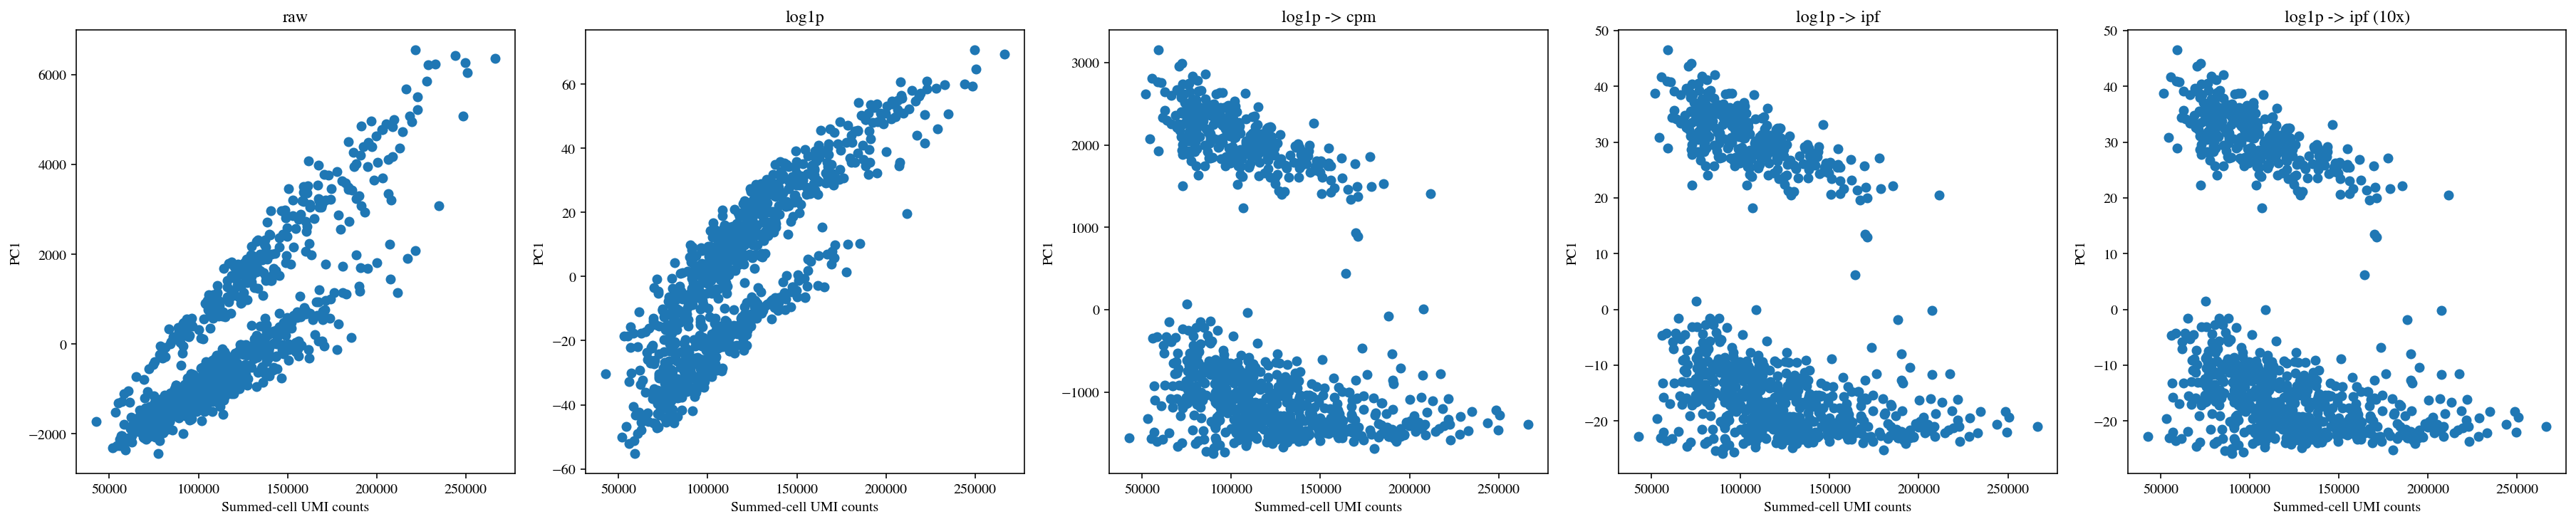

In [13]:
n = len(pcs)
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Summed-cell UMI counts",
    "ylabel": "PC1",
}

for idx, pc in enumerate(pcs):
  ax = axs[idx]
  title = labels[idx]
  
  # raw sumed counts for all
  matrix = mtx

  x = matrix.sum(1)
  y = pc[:,0]
  ax.scatter(x, y)
  p.update({"title": title})
  ax.set(**p)

fig.show()

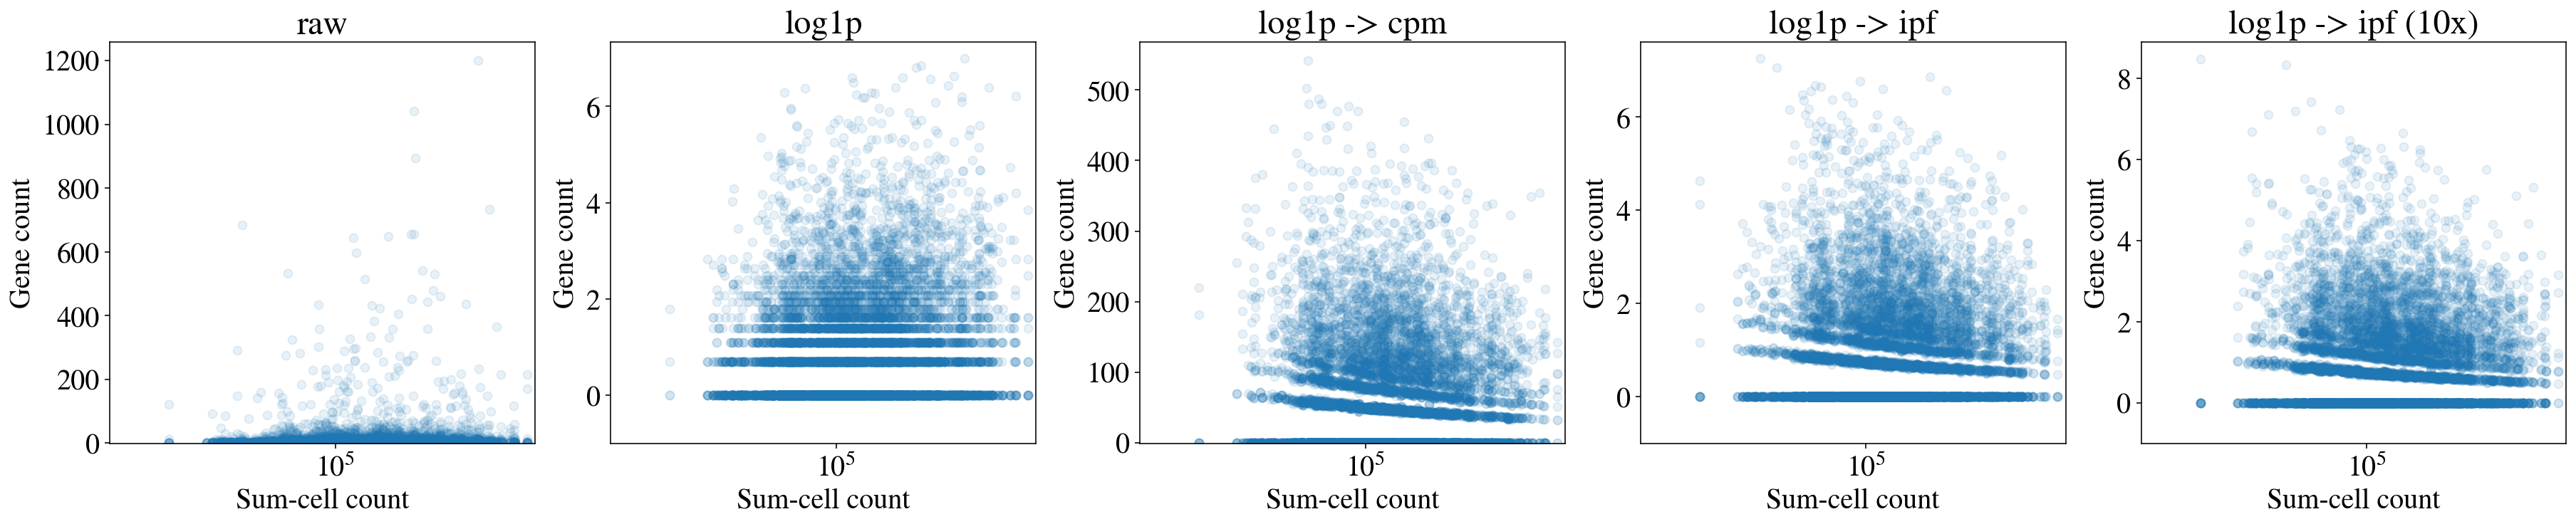

In [18]:
# fix ylim
n = len(matrices)
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Sum-cell count",
    "ylabel": "Gene count",
    "xscale": "symlog",
    # "yscale": "symlog",
    "ylim": (-1)
}

for idx, matrix in enumerate(matrices):

  ax = axs[idx]
  title = labels[idx]
  m, n = matrix.shape
  downsample_idx = np.random.choice(np.arange(n*m), size=10_000, replace=False)

  x = np.tile(mtx.sum(1), (mtx.shape[1],1)).T.flatten()
  y = matrix.flatten()
  ax.scatter(x[downsample_idx], y[downsample_idx], alpha=0.1)
  p.update({"title": title})
  ax.set(**p)
fig.show()

ENSG00000251562


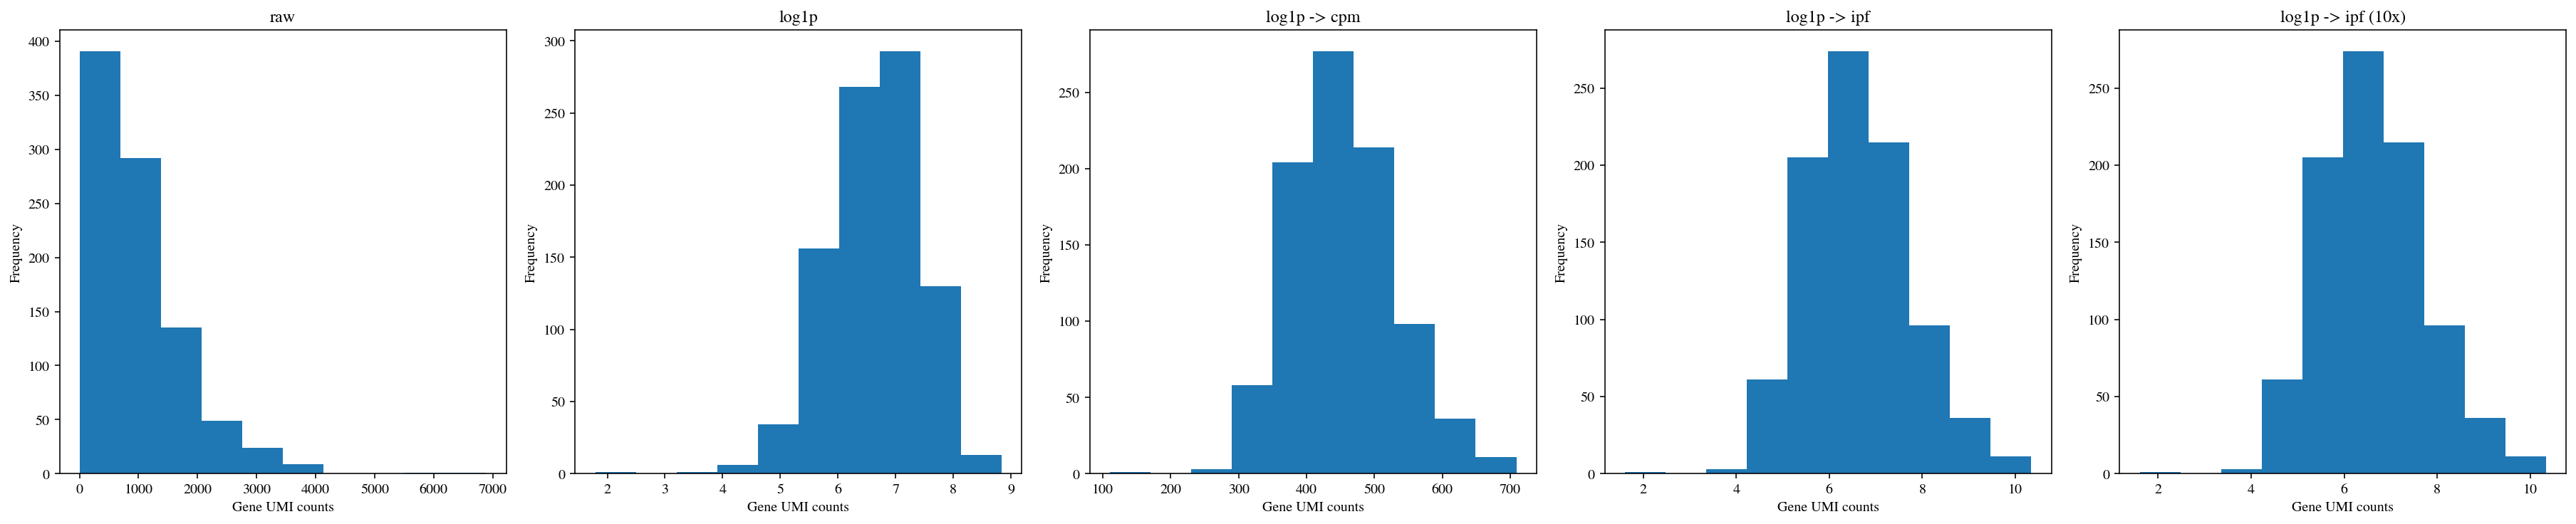

In [10]:
n = len(pcs)
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

argmax = np.argmax(mtx.sum(0))
print(genes[argmax])
p = {
    "xlabel": "Gene UMI counts",
    "ylabel": "Frequency",
}

for idx, matrix in enumerate(matrices):
  ax = axs[idx]
  title = labels[idx]

  g = matrix[:,argmax]
  ax.hist(g)
  p.update({"title": title})
  ax.set(**p)

fig.show()

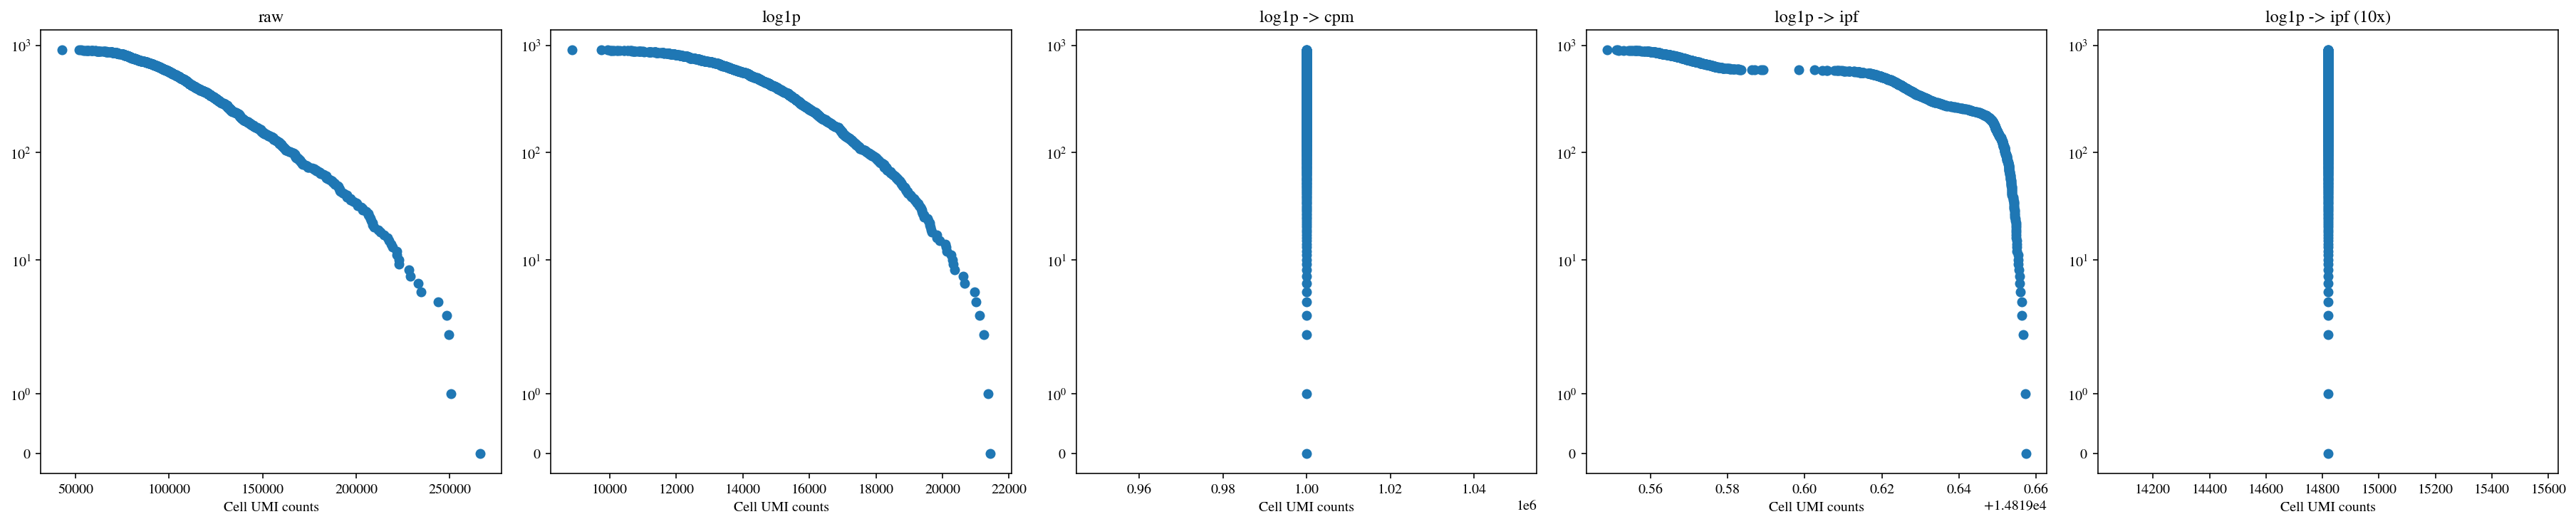

In [11]:
n = len(pcs)
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

p = {
    "xscale": "linear",
    "yscale": "symlog",
    "xlabel": "Cell UMI counts"
}

for idx, matrix in enumerate(matrices):
  ax = axs[idx]
  title = labels[idx]

  x = np.sort(matrix.sum(1))[::-1]
  y = np.arange(x.shape[0])

  ax.scatter(x,y)
  p.update({"title": title})
  ax.set(**p)

fig.show()

In [12]:
m1 = matrices[0]

rv = np.zeros((m1.shape[0], len(matrices)-1))

for idx, m2 in enumerate(matrices[1:]):
  for i in range(m1.shape[0]):
    r, p  = stats.spearmanr(m1[i], m2[i])
    rv[i, idx] = r

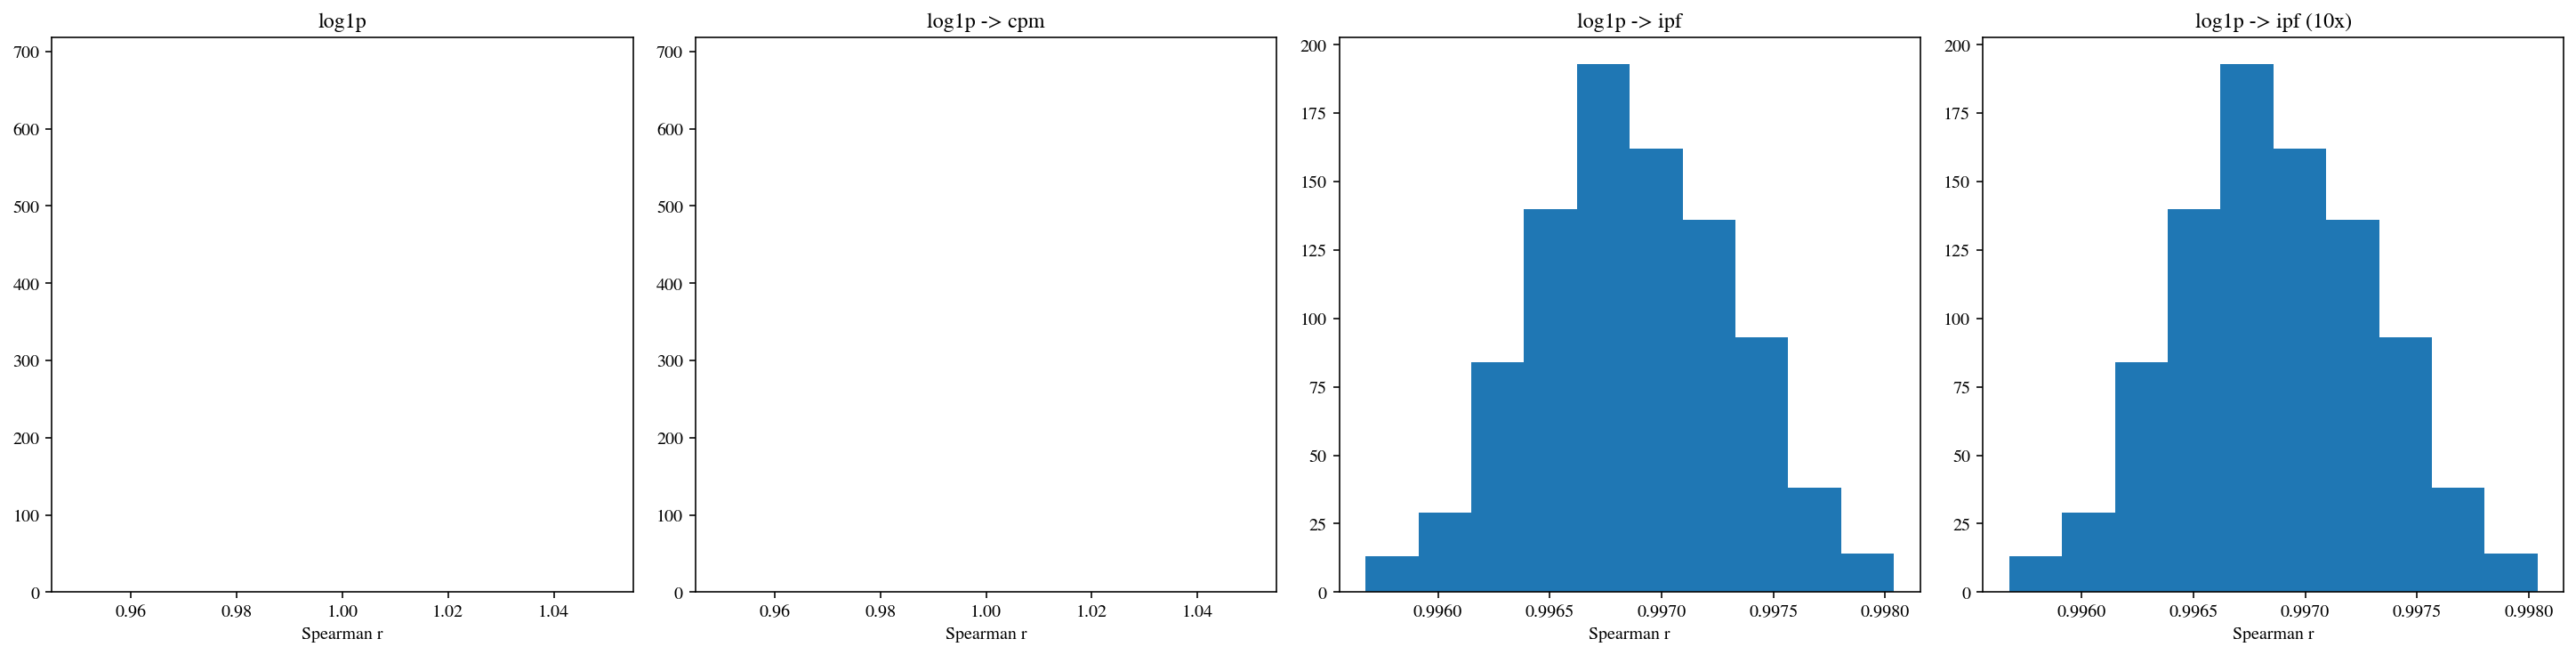

In [13]:
n = len(labels)-1
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Spearman r"
}

for idx, label in enumerate(labels[1:]):
  ax = axs[idx]
  x = rv[:,idx]

  ax.hist(x)
  p.update({"title": label})
  ax.set(**p)

fig.show()

# Angelidis

In [16]:
!wget --continue --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE124nnn/GSE124872/suppl/GSE124872_Angelidis_2018_metadata.csv.gz
!wget --continue --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE124nnn/GSE124872/suppl/GSE124872_raw_counts_single_cell.RData.gz
!gunzip *.gz

In [17]:
%load_ext rpy2.ipython

In [18]:
%%R
load("GSE124872_raw_counts_single_cell.RData")
library(Matrix)
writeMM(t(raw_counts), file = "matrix.mtx")
writeLines(rownames(raw_counts), "genes.txt")
writeLines(colnames(raw_counts), "barcodes.txt")

In [4]:
def read_str_list(fname, lst=list):
    with open(fname, "r") as f:
        for idx, line in enumerate(f.readlines()):
            lst.append(line.strip())

def sanitize_mtx(mtx: np.ndarray):
    cell_count_mask = mtx.sum(1) > 0  # count for each cell
    gene_count_mask = mtx.sum(0) > 0  # count for each gene

    genes_detected_mask = (mtx > 0).sum(1) > 0  # n genes per cell
    cells_detected_mask = (mtx > 0).sum(0) > 0  # n cells per gene
    row_mask = np.logical_and(cell_count_mask, genes_detected_mask)
    col_mask = np.logical_and(gene_count_mask, cells_detected_mask)

    return (row_mask, col_mask)

In [5]:
mtx = mmread("matrix.mtx").toarray()
md_bcs = pd.read_csv("GSE124872_Angelidis_2018_metadata.csv", index_col=0)
md_bcs["bcs"] = md_bcs.index.map(lambda x: x.split(":")[-1])
assignments = md_bcs.celltype.values

bcs = []
read_str_list("barcodes.txt", bcs)
bcs_fixed = [i.split(":")[-1] for i in bcs]
bcs = np.array(bcs_fixed)

genes = []
read_str_list("genes.txt", genes)
genes = np.array(genes)

In [6]:
mtx.shape

(14813, 21969)

In [7]:
# drop the all zero dudes
rm, cm = sanitize_mtx(mtx)
genes = genes[cm]
bcs = bcs[rm]
assignments = assignments[rm]
mtx = mtx[rm][:, cm]

In [8]:
n = 500
sample_bcs_idx = np.random.choice(np.arange(mtx.shape[0]), size=n, replace=False)

m = mtx.shape[1] # 10_000
sample_gene_idx = np.random.choice(np.arange(mtx.shape[1]), size=m, replace=False)

mtx_sub = mtx[sample_bcs_idx][:,sample_gene_idx]
bcs_sub = bcs[sample_bcs_idx]
assignments_sub = assignments[sample_bcs_idx]

genes_sub = genes[sample_gene_idx]

In [9]:
mtx_sub.shape

(500, 20908)

In [10]:
# log1p
mtx_log1p = np.log1p(mtx_sub)

# log1p -> ipf
mtx_log1p_ipf = do_ipf(mtx_log1p.copy(), axis_uniform=1)
mtx_log1p_ipf *= mtx_log1p.sum()

# log1p -> cpm
mtx_log1p_cpm = normalize(mtx_log1p, norm="l1")*1e6

# ipf -> log1p
mtx_ipf = do_ipf(mtx_sub.copy(), axis_uniform=1)
mtx_ipf *= mtx_sub.sum()
mtx_ipf_log1p = np.log1p(mtx_ipf)

# sf -> log1p
sf = mtx_sub.sum(1).flatten()
mtx_sf = mtx_sub / (sf / sf.mean())[:,None]
mtx_sf_log1p = np.log1p(mtx_sf)

# sf -> log1p -> sf
sf = mtx_sf_log1p.sum(1).flatten()
mtx_sf_log1p_sf = mtx_sf_log1p / (sf / sf.mean())[:,None]

# log then sf
sf = mtx_log1p.sum(1).flatten()
mtx_log1p_sf = mtx_log1p / (sf / sf.mean())[:,None]

# cpm -> log1p
mtx_cpm = normalize(mtx_sub, norm="l1")*1e6
mtx_cpm_log1p = np.log1p(mtx_cpm)

# ipf -> log1p -> ipf

mtx_log1p_ipf_log1p = do_ipf(mtx_ipf_log1p.copy(), axis_uniform=1)
mtx_log1p_ipf_log1p *= mtx_ipf_log1p.sum()

/usr/local/lib/python3.7/dist-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/usr/local/lib/python3.7/dist-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/usr/local/lib/python3.7/dist-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:


In [54]:
mtx_up = np.exp(mtx_sf_log1p_sf) - 1
# sf -> log1p
sf = mtx_up.sum(1).flatten()
mtx_sf = mtx_up / (sf / sf.mean())[:,None]
mtx_sf_log1p2 = np.log1p(mtx_sf)

# sf -> log1p -> sf
sf = mtx_sf_log1p2.sum(1).flatten()
mtx_sf_log1p_sf2 = mtx_sf_log1p2 / (sf / sf.mean())[:,None]

In [26]:
# log1p -> ipf (10x)
#mtx_multiple_ipf = iter_ipf(mtx, iter=2)

In [55]:
matrices = [
            mtx_sub, 
            mtx_log1p, 
            mtx_sf_log1p, 
            mtx_log1p_sf,
            mtx_sf_log1p_sf,
            mtx_sf_log1p_sf2,
            mtx_log1p_cpm, 
            mtx_cpm_log1p, 
            mtx_log1p_ipf, 
            mtx_ipf_log1p,
            mtx_log1p_ipf_log1p
          ]
labels = [
          "raw", 
          "log1p", 
          "sf -> log1p", 
          "log1p -> sf", 
          "sf -> log1p -> sf",
          "sf -> log1p -> sf (2x)",
          "log1p -> cpm", 
          "cpm -> log1p", 
          "log1p -> ipf", 
          "ipf -> log1p",
          "ipf -> log1p -> ipf"
]

## Marker genes

In [ ]:
table = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-08831-9/MediaObjects/41467_2019_8831_MOESM4_ESM.xlsx"

In [ ]:
excel = pd.read_excel(table)
df = excel.drop(columns=excel.columns[0], axis=1).rename(columns={"cluster": "celltype"})
df["celltype"] = df.celltype.str.replace(" ", "_")

In [ ]:
max_pval = 1e-10
min_lfc = 0.75
max_gene_shares = 2

# filter by criteria
dfc = df.query(f"p_val_adj <= {max_pval} & avg_logFC >= {min_lfc}")

# mask out genes that are shared between max_gene_shares cell type
non_repeat_genes = dfc["gene"].value_counts()[dfc["gene"].value_counts() < max_gene_shares].index.values

m = dfc[dfc.gene.isin(non_repeat_genes)]

# max number to sample is equal to the min number of genes across all celltype
n_sample = m["celltype"].value_counts().min()

In [ ]:
# sample n_sample genes
markers = m.groupby("celltype").sample(n=n_sample)
markers_dict = markers.groupby("celltype")["gene"].apply(lambda x: list(x)).to_dict()

In [ ]:
markers.sort_values("avg_logFC", ascending=False).celltype.unique()

array(['red_blood_cells', 'Fn1+_macrophage', 'Goblet_cells',
       'Plasma_cells', 'Smooth_muscle_cells',
       'CD209+/Cd11b+_dendritic_cells', 'Eosinophils',
       'Natural_Killer_cells', 'Type1_pneumocytes', 'Mesothelial_cells',
       'Interstitial_Fibroblast', 'Vcam1+_endothelial_cells',
       'Megakaryocytes', 'lymphatic_endothelial_cells',
       'Capillary_endothelial_cells', 'Cd103+/Cd11b-_dendritic_cells',
       'Neutrophils', 'vascular_endothelial_cells',
       'non-classical_monocyte_(Ly6c2-)', 'Alveolar_macrophage',
       'B_cells', 'Ccl17+/Cd103-/Cd11b-_dendritic_cells',
       'Mki67+_proliferating_cells', 'Cd4+_T_cells', 'Ciliated_cells',
       'Club_cells', 'Type_2_pneumocytes', 'Lipofibroblast',
       'classical_monocyte_(Ly6c2+)', 'CD8+_T_cells',
       'Interstitial_macrophages'], dtype=object)

## Depth normalization

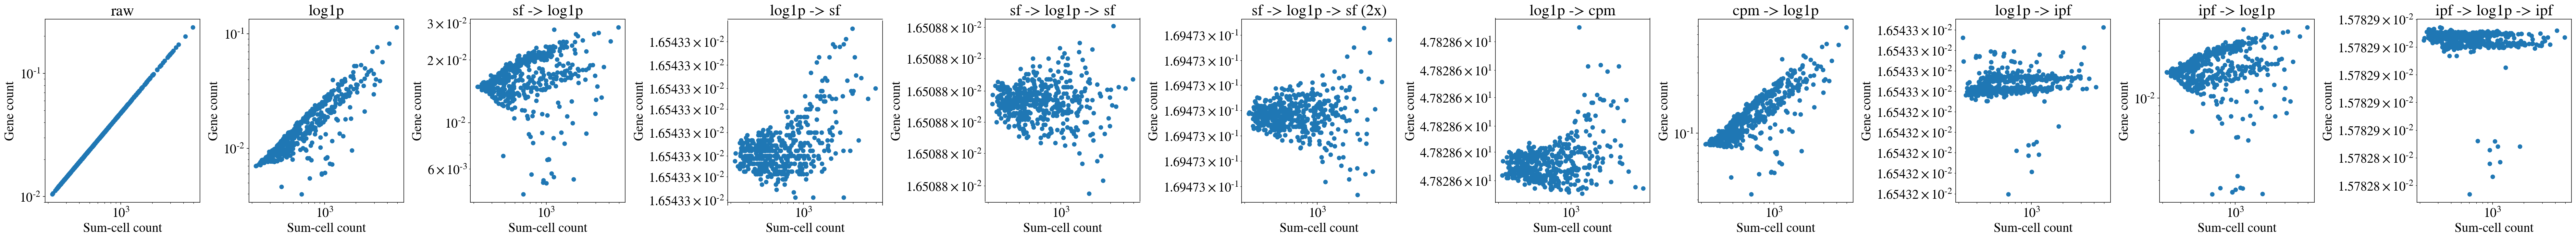

In [56]:
# fix ylim
n = len(matrices)
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Sum-cell count",
    "ylabel": "Gene count",
    "xscale": "log",
    "yscale": "log",
}

for idx, matrix in enumerate(matrices):

  ax = axs[idx]
  title = labels[idx]
  
  # m, n = matrix.shape
  # downsample_idx = np.random.choice(np.arange(n*m), size=100_000, replace=False)
  # x = np.tile(mtx.sum(1), (mtx.shape[1],1)).T.flatten()
  # y = matrix.flatten()
  # mask = y[downsample_idx] > 0
  # print(mask.sum(), "\t", title)
  # ax.scatter(x[downsample_idx][mask], y[downsample_idx][mask])
  x = np.sum(mtx_sub, 1)
  y = np.mean(matrix, 1)
  ax.scatter(x,y)

  p.update({"title": title})
  ax.set(**p)
fig.show()

## Marker Genes

In [57]:
celltype = "Type_2_pneumocytes"
gene = "Sftpc"

gene_mask = genes_sub == gene
ct_mask = assignments_sub == celltype
size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

raw Ks_2sampResult(statistic=0.8866666666666667, pvalue=4.879938980963165e-62)
log1p Ks_2sampResult(statistic=0.8866666666666667, pvalue=4.879938980963165e-62)
sf -> log1p Ks_2sampResult(statistic=0.9066666666666666, pvalue=8.600928185744819e-66)
log1p -> sf Ks_2sampResult(statistic=0.6933333333333334, pvalue=9.0288456597289e-35)
sf -> log1p -> sf Ks_2sampResult(statistic=0.88, pvalue=7.672348508958754e-61)
sf -> log1p -> sf (2x) Ks_2sampResult(statistic=0.30666666666666664, pvalue=1.247805517679719e-06)
log1p -> cpm Ks_2sampResult(statistic=0.6933333333333334, pvalue=9.0288456597289e-35)
cpm -> log1p Ks_2sampResult(statistic=0.9066666666666666, pvalue=8.600928185744819e-66)
log1p -> ipf Ks_2sampResult(statistic=0.6533333333333333, pvalue=1.5585523187859256e-30)
ipf -> log1p Ks_2sampResult(statistic=0.9133333333333333, pvalue=4.1955747247535705e-67)
ipf -> log1p -> ipf Ks_2sampResult(statistic=0.8733333333333333, pvalue=1.1387380418559837e-59)


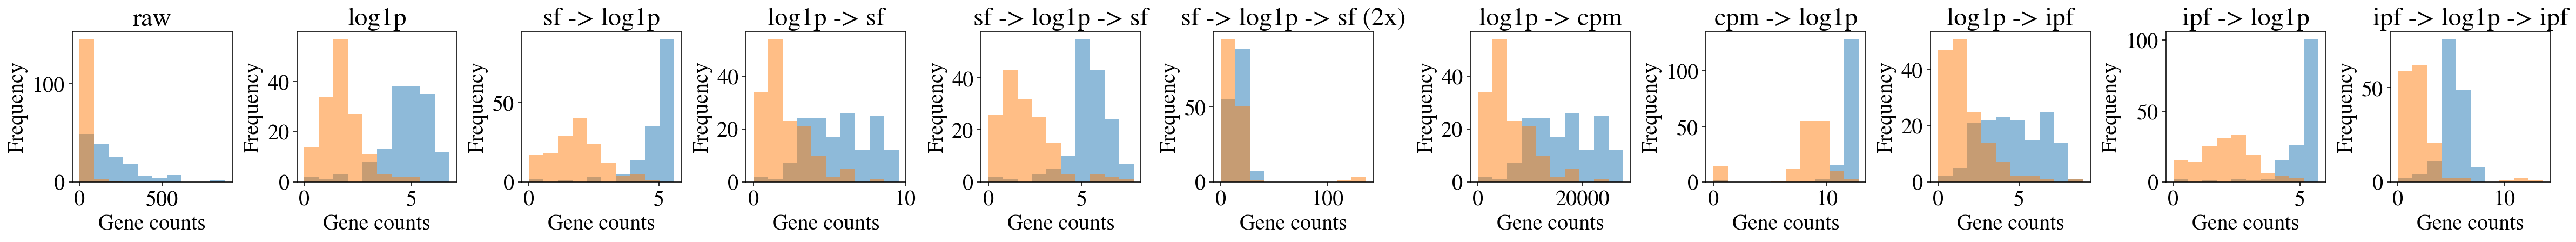

In [58]:
n = len(matrices)
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Gene counts",
    "ylabel": "Frequency",
}

for idx, matrix in enumerate(matrices):
  ax = axs[idx]
  title = labels[idx]

  v_gene = matrix[:, gene_mask].flatten()
  t = v_gene[ct_mask]
  c = v_gene[~ct_mask][downsample_idx]
  print(title, stats.ks_2samp(t, c))
  bins = np.histogram(np.hstack((t,c)), bins=10)[1] #get the bin edges 
  ax.hist(t, label="target", alpha=0.5, bins=bins)
  ax.hist(c, label="complement", alpha=0.5, bins=bins)

  p.update({"title": title})
  ax.set(**p)

fig.show()

In [42]:
celltype1 = "Goblet_cells"
celltype2 = "Club_cells"

ct_mask1 = assignments_sub == celltype1
ct_mask2 = assignments_sub == celltype2

ct_mask = np.logical_or(ct_mask1, ct_mask2)

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

gene = "Scgb1a1"

gene_mask = genes_sub == gene

raw Ks_2sampResult(statistic=0.9090909090909091, pvalue=1.2676903834766066e-14)
log1p Ks_2sampResult(statistic=0.9090909090909091, pvalue=1.2676903834766066e-14)
sf -> log1p Ks_2sampResult(statistic=0.9393939393939394, pvalue=5.942298672546593e-16)
log1p -> sf Ks_2sampResult(statistic=0.8181818181818182, pvalue=2.5170626409119765e-11)
sf -> log1p -> sf Ks_2sampResult(statistic=0.8787878787878788, pvalue=1.9966123539756554e-13)
log1p -> cpm Ks_2sampResult(statistic=0.8181818181818182, pvalue=2.5170626409119765e-11)
cpm -> log1p Ks_2sampResult(statistic=0.9393939393939394, pvalue=5.942298672546593e-16)
log1p -> ipf Ks_2sampResult(statistic=0.7878787878787878, pvalue=2.157482263638837e-10)
ipf -> log1p Ks_2sampResult(statistic=0.9393939393939394, pvalue=5.942298672546593e-16)
ipf -> log1p -> ipf Ks_2sampResult(statistic=0.8787878787878788, pvalue=1.9966123539756554e-13)


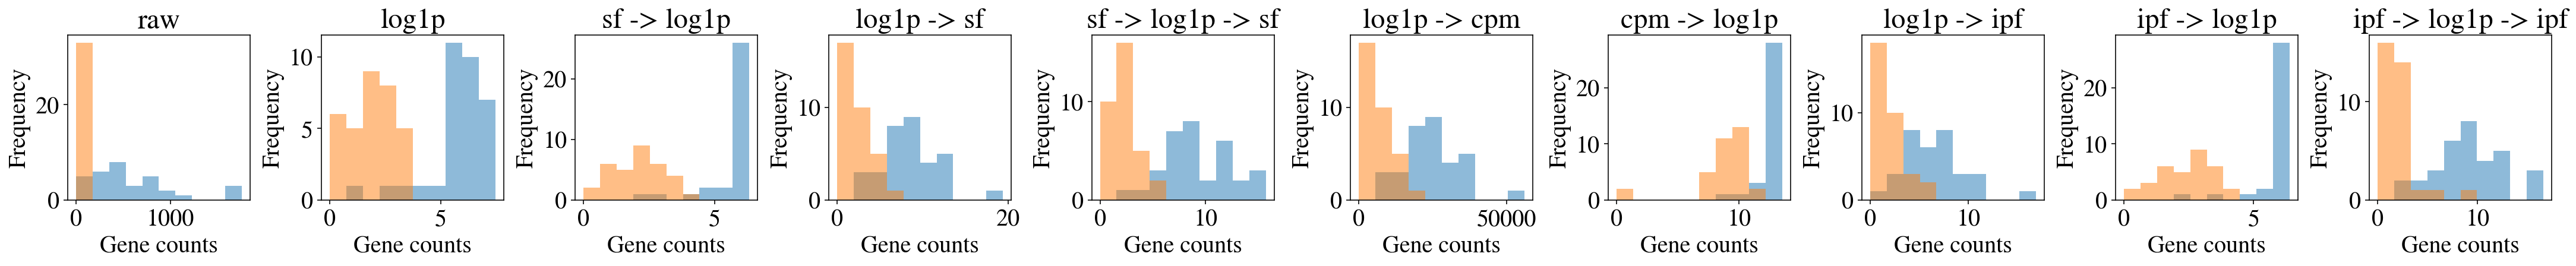

In [43]:
n = len(matrices)
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Gene counts",
    "ylabel": "Frequency",
}

for idx, matrix in enumerate(matrices):
  ax = axs[idx]
  title = labels[idx]

  v_gene = matrix[:, gene_mask].flatten()
  t = v_gene[ct_mask]
  c = v_gene[~ct_mask][downsample_idx]
  print(title, stats.ks_2samp(t, c))
  bins = np.histogram(np.hstack((t,c)), bins=10)[1] #get the bin edges

  ax.hist(t, label="target", alpha=0.5, bins=bins)
  ax.hist(c, label="complement", alpha=0.5, bins=bins)

  p.update({"title": title})
  ax.set(**p)

fig.show()

In [44]:
celltype = "Alveolar_macrophage"
gene = "Ear2"

ct_mask = assignments_sub == celltype
gene_mask = genes_sub == gene

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

raw Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)
log1p Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)
sf -> log1p Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)
log1p -> sf Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)
sf -> log1p -> sf Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)
log1p -> cpm Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)
cpm -> log1p Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)
log1p -> ipf Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)
ipf -> log1p Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)
ipf -> log1p -> ipf Ks_2sampResult(statistic=0.6, pvalue=3.275485736264578e-11)


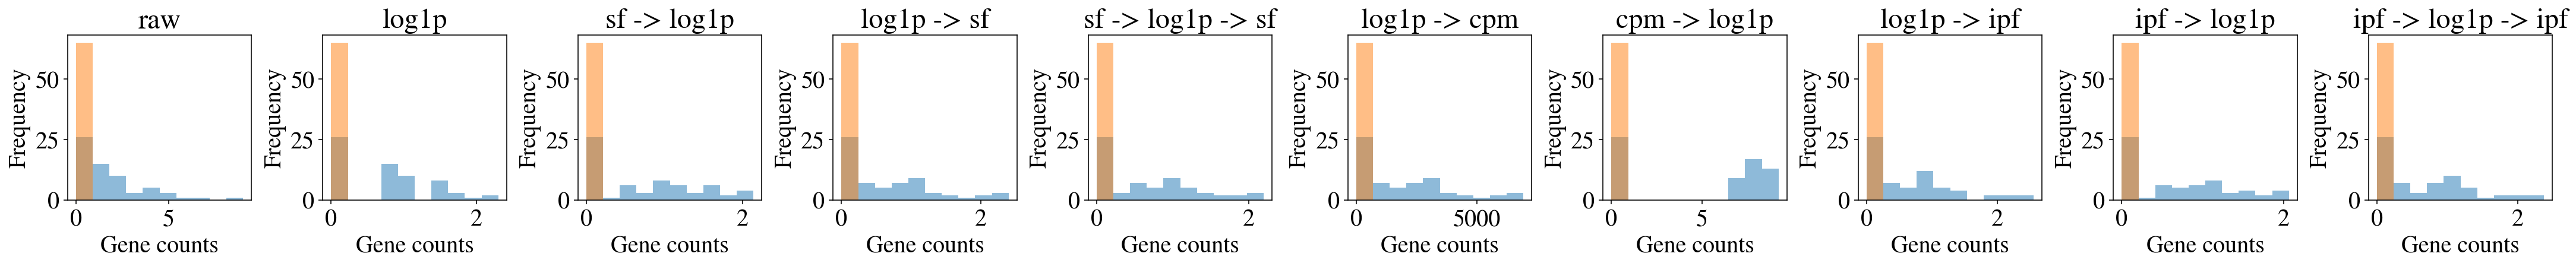

In [45]:
n = len(matrices)
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Gene counts",
    "ylabel": "Frequency",
}

for idx, matrix in enumerate(matrices):
  ax = axs[idx]
  title = labels[idx]

  v_gene = matrix[:, gene_mask].flatten()
  t = v_gene[ct_mask]
  c = v_gene[~ct_mask][downsample_idx]
  print(title, stats.ks_2samp(t, c))
  bins = np.histogram(np.hstack((t,c)), bins=10)[1] #get the bin edges 
  ax.hist(t, label="target", alpha=0.5, bins=bins)
  ax.hist(c, label="complement", alpha=0.5, bins=bins)

  p.update({"title": title})
  ax.set(**p)

fig.show()

raw 64193.53722093558
log1p 0.0025690065608806392
sf -> log1p 0.0025610167531435316
log1p -> sf 0.008679477268651693
sf -> log1p -> sf 0.008270271409239456
log1p -> cpm 606401037795.711
cpm -> log1p 3.3205226553416316
log1p -> ipf 0.004495349805053163
ipf -> log1p 0.002771896724374527
ipf -> log1p -> ipf 0.007714596195155602


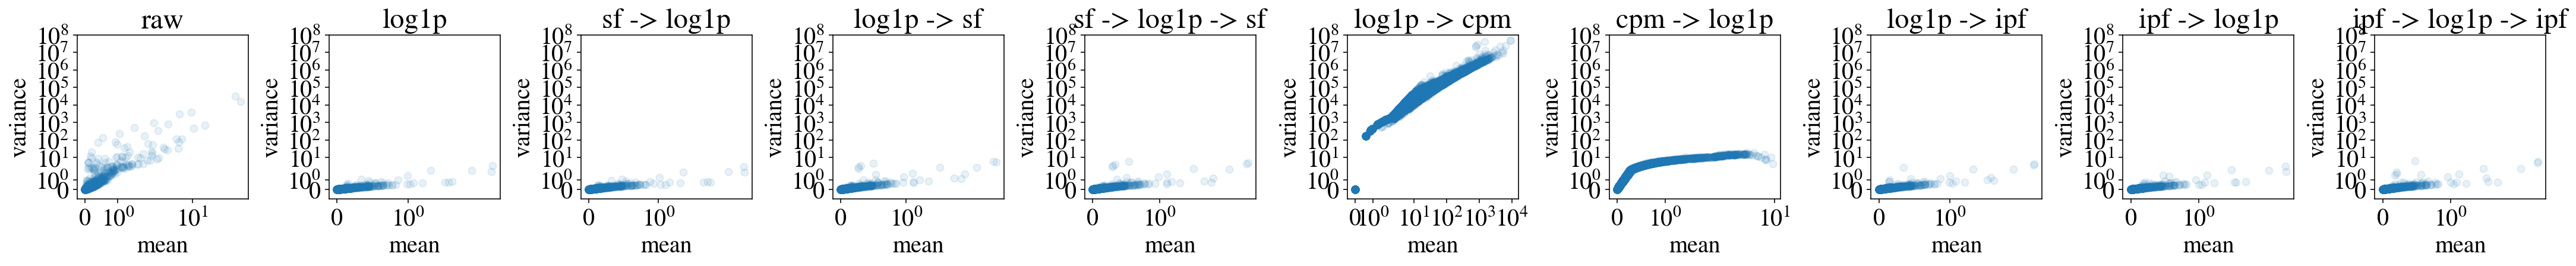

In [46]:
# fix ylim
n = len(matrices)
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xlabel": "mean",
    "ylabel": "variance",
    "xscale": "symlog",
    "yscale": "symlog",
    "ylim": (-1, 1e8)
}

for idx, matrix in enumerate(matrices):

  ax = axs[idx]
  title = labels[idx]

  x = np.mean(matrix, axis=0)
  y = np.var(matrix, axis=0)
  print(title, np.var(y))
  ax.scatter(x, y, alpha=0.1)
  p.update({"title": title})
  ax.set(**p)

fig.show()

In [52]:
pcs = []
for matrix in matrices:
  pca = PCA(n_components=50, svd_solver='full')
  Y = pca.fit_transform(matrix)
  pcs.append(Y)

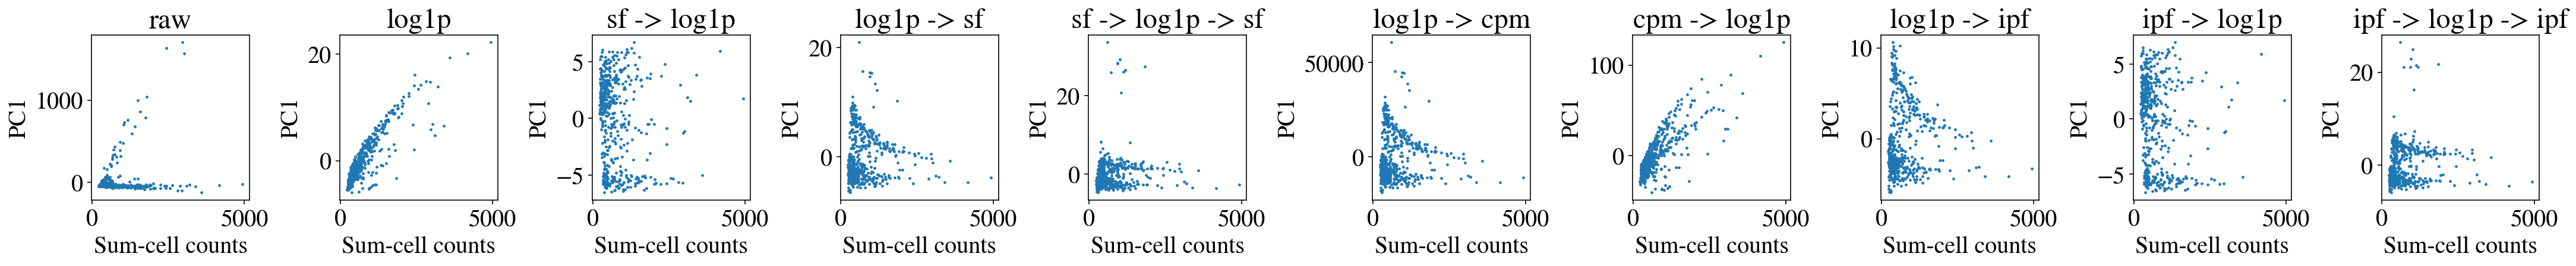

In [53]:
n = len(pcs)
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Sum-cell counts",
    "ylabel": "PC1",
}

for idx, pc in enumerate(pcs):
  ax = axs[idx]
  title = labels[idx]
  
  # raw summed counts for all
  matrix = mtx_sub

  x = matrix.sum(1)
  y = pc[:,0]
  ax.scatter(x, y, s=2)
  p.update({"title": title})
  ax.set(**p)

fig.show()

In [47]:
n = len(pcs)
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

argmax = np.argmax(mtx_sub.sum(0))
print(genes[argmax])
p = {
    "xlabel": "Gene UMI counts",
    "ylabel": "Frequency",
}

for idx, matrix in enumerate(matrices):
  ax = axs[idx]
  title = labels[idx]

  g = matrix[:,argmax]
  ax.hist(g)
  p.update({"title": title})
  ax.set(**p)

fig.show()

NameError: ignored

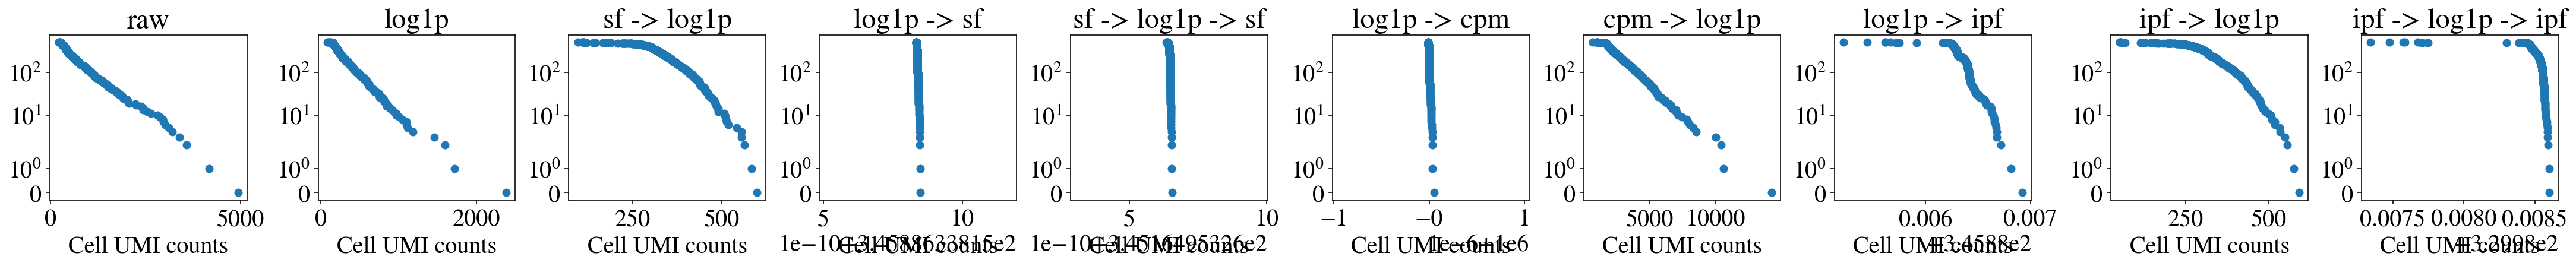

In [48]:
n = len(matrices)
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xscale": "linear",
    "yscale": "symlog",
    "xlabel": "Cell UMI counts"
}

for idx, matrix in enumerate(matrices):
  ax = axs[idx]
  title = labels[idx]

  x = np.sort(matrix.sum(1))[::-1]
  y = np.arange(x.shape[0])

  ax.scatter(x,y)
  p.update({"title": title})
  ax.set(**p)

fig.show()

raw 0.8094367391822869
log1p 0.6824393544456021
sf -> log1p 0.22317630448465287
log1p -> sf 6.6027059437806974e-15
sf -> log1p -> sf 7.171609590875684e-15
log1p -> cpm 7.554114793548193e-15
cpm -> log1p 0.5074709725748727
log1p -> ipf 4.006267777867511e-07
ipf -> log1p 0.25824382320011746
ipf -> log1p -> ipf 3.863842449346026e-07


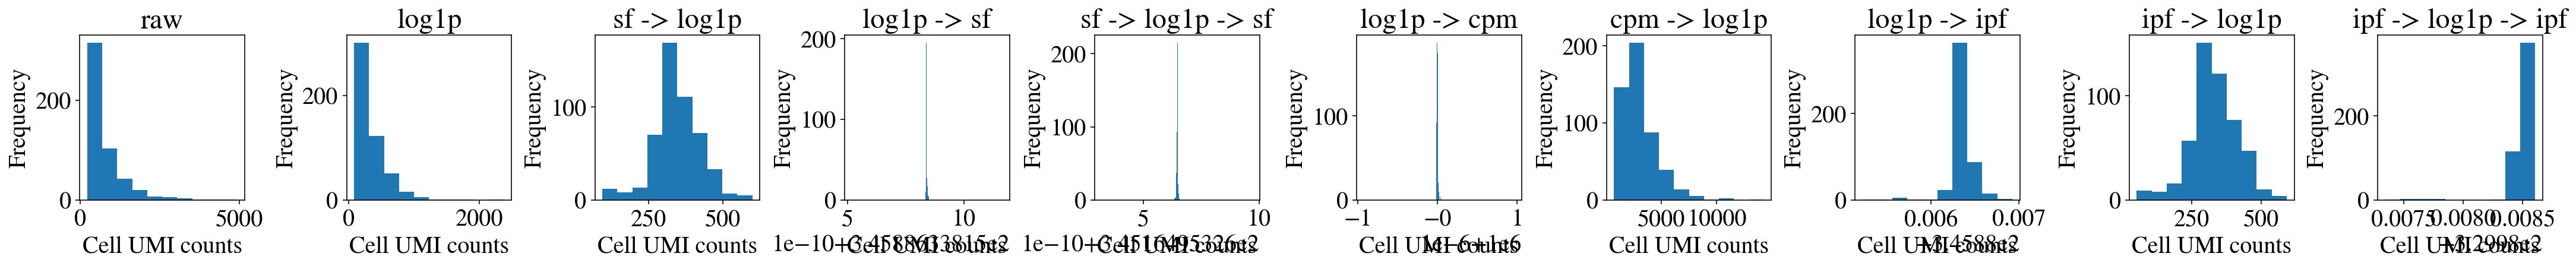

In [49]:
n = len(matrices)
fig, axs = plt.subplots(figsize=(3*n,3), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Cell UMI counts",
    "ylabel": "Frequency",
}

for idx, matrix in enumerate(matrices):
  ax = axs[idx]
  title = labels[idx]

  x = np.sort(matrix.sum(1))[::-1]
  print(title, np.sqrt(np.var(x))/np.mean(x))

  ax.hist(x)
  p.update({"title": title})
  ax.set(**p)

fig.show()

In [50]:
m1 = matrices[0]

rv = np.zeros((m1.shape[0], len(matrices)-1))

for idx, m2 in enumerate(matrices[1:]):
  for i in range(m1.shape[0]):
    r, p  = stats.spearmanr(m1[i], m2[i])
    rv[i, idx] = r

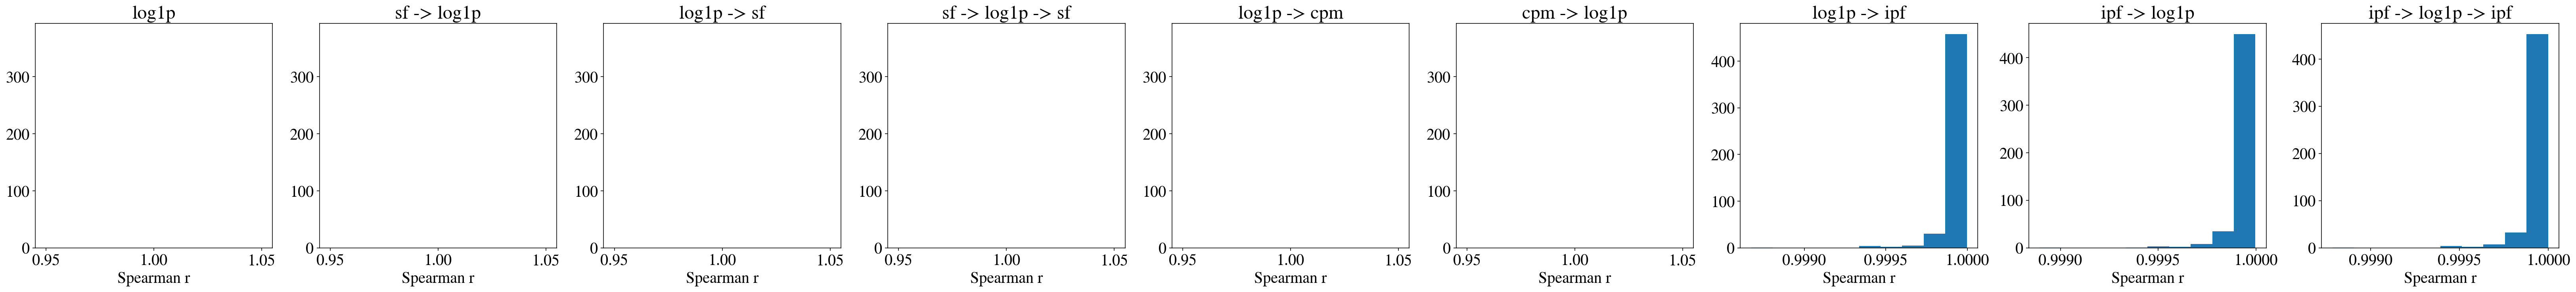

In [51]:
n = len(labels)-1
fig, axs = plt.subplots(figsize=(5*n,5), ncols=n, constrained_layout=True)

p = {
    "xlabel": "Spearman r"
}

for idx, label in enumerate(labels[1:]):
  ax = axs[idx]
  x = rv[:,idx]

  ax.hist(x)
  p.update({"title": label})
  ax.set(**p)

fig.show()